Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D,MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/skin_cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/skin_cancer/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

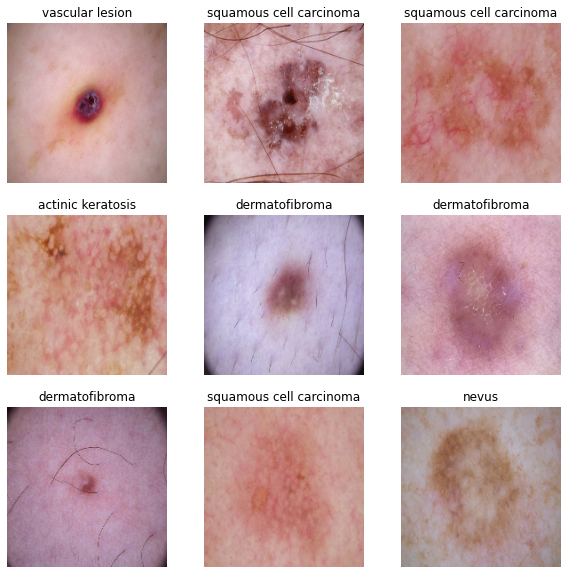

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### normalise the data
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "sigmoid"))


0.038235296 0.96617657


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 514s 2s/step - loss: 1.3977 - accuracy: 0.4558 - val_loss: 1.2484 - val_accuracy: 0.5234
Epoch 2/20
281/281 [==============================] - 17s 60ms/step - loss: 1.1379 - accuracy: 0.5702 - val_loss: 1.0049 - val_accuracy: 0.6208
Epoch 3/20
281/281 [==============================] - 17s 60ms/step - loss: 0.9217 - accuracy: 0.6601 - val_loss: 0.9013 - val_accuracy: 0.6466
Epoch 4/20
281/281 [==============================] - 17s 60ms/step - loss: 0.7774 - accuracy: 0.7152 - val_loss: 0.8038 - val_accuracy: 0.7089
Epoch 5/20
281/281 [==============================] - 17s 60ms/step - loss: 0.6365 - accuracy: 0.7657 - val_loss: 0.5794 - val_accuracy: 0.7997
Epoch 6/20
281/281 [==============================] - 17s 59ms/step - loss: 0.5414 - accuracy: 0.8026 - val_loss: 0.6517 - val_accuracy: 0.7588
Epoch 7/20
281/281 [==============================] - 17s 59ms/step - loss: 0.4729 - accuracy: 0.8266 - val_loss: 0.5029 - val_accuracy: 

### Visualizing training results

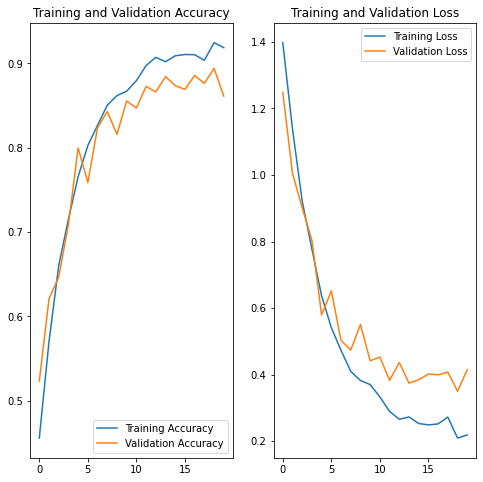

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Observation:
The model overfits

The training accuracy is increasing while the validation accuracy is decreasing after 70%.

The training loss decreases after each epoch but validation loss increases again after the 10th epoch.

The model memorized the data instead of generalizing and learning main features.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

with tf.device('/cpu:0'):
  data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
  ])

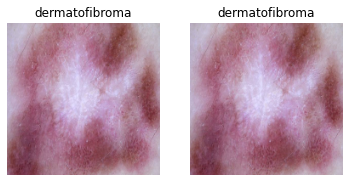

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

for image, label in train_ds.take(1):
  ax = plt.subplot(1, 2, 1)
  plt.imshow(image[0].numpy().astype('uint8'))
  plt.title(class_names[label.numpy()[0]])
  plt.axis('off')

  augmented = data_augmentation(image)
  ax = plt.subplot(1, 2, 2)
  plt.imshow(augmented[0].numpy().astype('uint8'))
  plt.title(class_names[label.numpy()[0]])
  plt.axis('off')

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 17s 59ms/step - loss: 1.9642 - accuracy: 0.2193 - val_loss: 1.7918 - val_accuracy: 0.3129
Epoch 2/20
281/281 [==============================] - 17s 59ms/step - loss: 1.4917 - accuracy: 0.4165 - val_loss: 1.3031 - val_accuracy: 0.4891
Epoch 3/20
281/281 [==============================] - 17s 59ms/step - loss: 1.2670 - accuracy: 0.5165 - val_loss: 1.1596 - val_accuracy: 0.5416
Epoch 4/20
281/281 [==============================] - 16s 58ms/step - loss: 1.0848 - accuracy: 0.5932 - val_loss: 0.9890 - val_accuracy: 0.6333
Epoch 5/20
281/281 [==============================] - 17s 59ms/step - loss: 0.9126 - accuracy: 0.6583 - val_loss: 0.8063 - val_accuracy: 0.7103
Epoch 6/20
281/281 [==============================] - 17s 59ms/step - loss: 0.7497 - accuracy: 0.7279 - val_loss: 0.7275 - val_accuracy: 0.7303
Epoch 7/20
281/281 [==============================] - 16s 59ms/step - loss: 0.6532 - accuracy: 0.7625 - val_loss: 0.6557 - val_accuracy:

### Visualizing the results

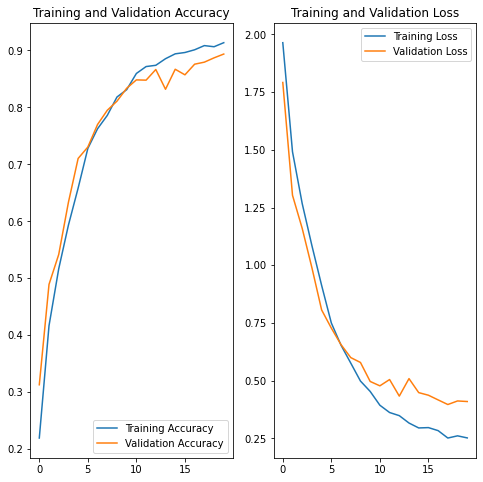

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- Data augmentation and dropout layer reduced the overfitting
- There is a minute difference between Training and Validation Accuracy
- Training and Validation Loss also having the similar decrease.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/skin_cancer/Train/act...,actinic keratosis
1,/content/gdrive/My Drive/skin_cancer/Train/act...,actinic keratosis
2,/content/gdrive/My Drive/skin_cancer/Train/act...,actinic keratosis
3,/content/gdrive/My Drive/skin_cancer/Train/act...,actinic keratosis
4,/content/gdrive/My Drive/skin_cancer/Train/act...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/skin_cancer/Train/vas...,vascular lesion
2235,/content/gdrive/My Drive/skin_cancer/Train/vas...,vascular lesion
2236,/content/gdrive/My Drive/skin_cancer/Train/vas...,vascular lesion
2237,/content/gdrive/My Drive/skin_cancer/Train/vas...,vascular lesion


<BarContainer object of 9 artists>

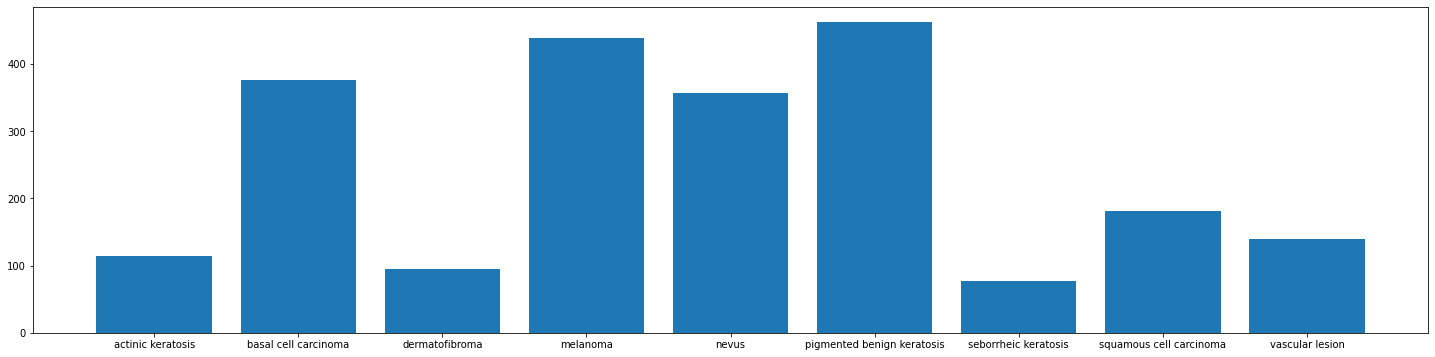

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,6))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
      - seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?

      - basal cell carcinoma
      - melanoma
      - nevus
      - pigmented benign


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/My Drive/skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA82A1851C0>: 100%|██████████| 500/500 [00:21<00:00, 23.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA82A14D7C0>: 100%|██████████| 500/500 [00:26<00:00, 19.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA82A1FA070>: 100%|██████████| 500/500 [00:22<00:00, 21.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA82A166190>: 100%|██████████| 500/500 [01:30<00:00,  5.52 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA82A7E5880>: 100%|██████████| 500/500 [01:24<00:00,  5.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA82A0FCA90>: 100%|██████████| 500/500 [00:17<00:00, 28.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA8420697C0>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA82A1B7A60>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA82A10E160>: 100%|██████████| 500/500 [00:17<00:00, 28.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
from glob import glob

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/My Drive/skin_cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)) ])
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


394/394 [==============================] - 74s 183ms/step - loss: 1.7453 - accuracy: 0.3123 - val_loss: 1.4827 - val_accuracy: 0.4150
Epoch 2/50
394/394 [==============================] - 73s 182ms/step - loss: 1.3912 - accuracy: 0.4552 - val_loss: 1.2909 - val_accuracy: 0.4843
Epoch 3/50
394/394 [==============================] - 72s 179ms/step - loss: 1.1694 - accuracy: 0.5518 - val_loss: 0.9834 - val_accuracy: 0.6358
Epoch 4/50
394/394 [==============================] - 68s 170ms/step - loss: 0.9665 - accuracy: 0.6412 - val_loss: 0.8242 - val_accuracy: 0.7026
Epoch 5/50
394/394 [==============================] - 76s 191ms/step - loss: 0.7970 - accuracy: 0.7076 - val_loss: 0.6775 - val_accuracy: 0.7471
Epoch 6/50
394/394 [==============================] - 68s 169ms/step - loss: 0.6597 - accuracy: 0.7610 - val_loss: 0.5655 - val_accuracy: 0.7928
Epoch 7/50
394/394 [==============================] - 63s 156ms/step - loss: 0.5536 - accuracy: 0.8007 - val_loss: 0.5384 - val_accuracy: 0.8

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Training and Validation Accuracy increased to greater than 95% at epoch 10. The model is almost learned and generalised, so using more epochs could also helps in increasing the performance. There is a minute gap bewteen training and validation, so still the model overfitting. Using more epochs might fit. Class rebalancing helped to reduce overfitting and improved the Validation Accuracy aswell from 80% to 90% at epoch 5.

